## TODO


- Baysian hyper paramater optimization
- Increase model size
- Increase dropout
- Increase batch size and implement caching

# Imports

Import the required libraries.

In [1]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors
import tensorflow as tf
import collections
import datetime
import timeit
import os
import glob
import random
from keras import backend as K
from keras import metrics
import numpy as np
from keras import mixed_precision
from keras import Input
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate, Conv2D
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, LeakyReLU
from tensorflow.keras.layers import Add, concatenate, UpSampling2D, Lambda, multiply
from tensorflow.keras.models import Model, Sequential
import tensorflow_datasets as tfds
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc
from matplotlib import pyplot
from skopt.space.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
#### For testing purposes
random.seed(1144)
###

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [3]:
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

In [4]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')

tf.keras.mixed_precision.set_global_policy(policy)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080, compute capability 8.6


In [5]:
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Load the dataset

Enter the Unix glob file pattern of the data files.

Here we load the training data. All the data are stored in TensorFlow Record files.
Replace 'train' with 'eval' or 'test' to load the evaluation or testing data, respectively.

Run the following three cells to define the required library functions for loading the data.

The first cell defines the name of the variables in the input files and the corrresponding data statistics. The statistics can be used for preprocessing the data. 

In [6]:
"""Constants for the data reader."""

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']


OUTPUT_FEATURES = ['detectionImage']

# Data statistics 
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, standard deviation)
DATA_STATS = {
    # Elevation in m.
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    
    # Drought Index (Palmer Drought Severity Index)
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),
    
    #Vegetation index (times 10,000 maybe, since it's supposed to be b/w -1 and 1?)
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max
   
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.53038024902344, 1.7398051, 4.482833),
   
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.32976, 72.59854),
    
    # Min/max temperature in Kelvin.
    
    #Min temp
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.94891357421875, 281.08768, 8.982386),
    
    #Max temp
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.09228515625, 295.17383, 9.815496),
    
    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.024310074806237, 3.8500874, 1.4109988),
    
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),
    
    # Population density
    # min, 99.9 percentile
    'population': (0., 2534.06298828125, 25.531384, 154.72331),
    
    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    'PrevFireMask': (0., 1., 0., 1.),
    'detectionImage': (0, 1., 0., 1.)
}

The following cell defines cropping functions for extracting regions of the desired size from the input data.

In [7]:
"""Library of common functions used in deep learning neural networks.
"""
#YOU PROBABLY WILL NOT USE THESE.

def random_crop_input_and_output_images(
        input_img: tf.Tensor,
        output_img: tf.Tensor,
        sample_size: int,
        num_in_channels: int,
        num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Randomly axis-align crop input and output image tensors.

    Args:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
        sample_size: side length (square) to crop to.
        num_in_channels: number of channels in input_img.
        num_out_channels: number of channels in output_img.
    Returns:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
    """
    combined = tf.concat([input_img, output_img], axis=2)
    combined = tf.image.random_crop(
            combined,
            [sample_size, sample_size, num_in_channels + num_out_channels])
    input_img = combined[:, :, 0:num_in_channels]
    output_img = combined[:, :, -num_out_channels:]
    return input_img, output_img


def center_crop_input_and_output_images(
        input_img: tf.Tensor,
        output_img: tf.Tensor,
        sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Center crops input and output image tensors.

    Args:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
        sample_size: side length (square) to crop to.
    Returns:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
    """
    central_fraction = sample_size / input_img.shape[0]
    input_img = tf.image.central_crop(input_img, central_fraction)
    output_img = tf.image.central_crop(output_img, central_fraction)
    return input_img, output_img

The following cell provides code for parsing the contents of the TensorFlow Record files. In addition to loading the data, it also offers functions for various preprocessing operations, such as clipping, rescaling, or normalizing the data.  

In [8]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
    """Extracts the base key from the provided key.

    Earth Engine exports TFRecords containing each data variable with its
    corresponding variable name. In the case of time sequences, the name of the
    data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
    where 'variable' is the name of the variable, and n the number of elements
    in the time sequence. Extracting the base key ensures that each step of the
    time sequence goes through the same normalization steps.
    The base key obeys the following naming pattern: '([a-zA-Z]+)'
    For instance, for an input key 'variable_1', this function returns 'variable'.
    For an input key 'variable', this function simply returns 'variable'.

    Args:
        key: Input key.

    Returns:
        The corresponding base key.

    Raises:
        ValueError when `key` does not match the expected pattern.
    """
    match = re.match(r'([a-zA-Z]+)', key)
    if match:
        return match.group(1)
    raise ValueError(
            'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and rescales inputs with the stats corresponding to `key`.

    Args:
        inputs: Inputs to clip and rescale.
        key: Key describing the inputs.

    Returns:
        Clipped and rescaled input.

    Raises:
        ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
                'No data statistics available for the requested key: {}.'.format(key))
    min_val, max_val, _, _ = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and normalizes inputs with the stats corresponding to `key`.

    Args:
        inputs: Inputs to clip and normalize.
        key: Key describing the inputs.

    Returns:
        Clipped and normalized input.

    Raises:
        ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
                'No data statistics available for the requested key: {}.'.format(key))
    min_val, max_val, mean, std = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    inputs = inputs - mean
    return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
        sample_size: int,
        features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
    """Creates a features dictionary for TensorFlow IO.

    Args:
        sample_size: Size of the input tiles (square).
        features: List of feature names.

    Returns:
        A features dictionary for TensorFlow IO.
    """
    sample_shape = [sample_size, sample_size]
    features = set(features)
    columns = [
            tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
            for _ in features
    ]
    return dict(zip(features, columns))


def _parse_fn(
        example_proto: tf.train.Example, data_size: int, sample_size: int,
        num_in_channels: int, clip_and_normalize: bool,
        clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Reads a serialized example.

    Args:
        example_proto: A TensorFlow example protobuf.
        data_size: Size of tiles (square) as read from input files.
        sample_size: Size the tiles (square) when input into the model.
        num_in_channels: Number of input channels.
        clip_and_normalize: True if the data should be clipped and normalized.
        clip_and_rescale: True if the data should be clipped and rescaled.
        random_crop: True if the data should be randomly cropped.
        center_crop: True if the data should be cropped in the center.

    Returns:
        (input_img, output_img) tuple of inputs and outputs to the ML model.
    """
    if (random_crop and center_crop):
        raise ValueError('Cannot have both random_crop and center_crop be True')
    input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
    feature_names = input_features + output_features
    features_dict = _get_features_dict(data_size, feature_names)
    features = tf.io.parse_single_example(example_proto, features_dict)


    if clip_and_normalize:
        inputs_list = [
                _clip_and_normalize(features.get(key), key) for key in input_features
        ]
    elif clip_and_rescale:
        inputs_list = [
                _clip_and_rescale(features.get(key), key) for key in input_features
        ]
    else:
        inputs_list = [features.get(key) for key in input_features]

    inputs_stacked = tf.stack(inputs_list, axis=0)
    input_img = tf.transpose(inputs_stacked, [1, 2, 0])

    outputs_list = [features.get(key) for key in output_features]
    assert outputs_list, 'outputs_list should not be empty'
    outputs_stacked = tf.stack(outputs_list, axis=0)

    outputs_stacked_shape = outputs_stacked.get_shape().as_list()
    assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
    output_img = tf.transpose(outputs_stacked, [1, 2, 0])

    if random_crop:
        input_img, output_img = random_crop_input_and_output_images(
                input_img, output_img, sample_size, num_in_channels, 1)
    if center_crop:
        input_img, output_img = center_crop_input_and_output_images(
                input_img, output_img, sample_size)
    return input_img, output_img


def get_dataset(fileNames: list[str], data_size: int, sample_size: int,
                                batch_size: int, num_in_channels: int, compression_type: Text,
                                clip_and_normalize: bool, clip_and_rescale: bool,
                                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
    """Gets the dataset from the file pattern.

    Args:
        file_pattern: Input file pattern.
        data_size: Size of tiles (square) as read from input files.
        sample_size: Size the tiles (square) when input into the model.
        batch_size: Batch size.
        num_in_channels: Number of input channels.
        compression_type: Type of compression used for the input files.
        clip_and_normalize: True if the data should be clipped and normalized, False
            otherwise.
        clip_and_rescale: True if the data should be clipped and rescaled, False
            otherwise.
        random_crop: True if the data should be randomly cropped.
        center_crop: True if the data shoulde be cropped in the center.

    Returns:
        A TensorFlow dataset loaded from the input file pattern, with features
        described in the constants, and with the shapes determined from the input
        parameters to this function.
    """
    options = tf.data.Options()
    options.experimental_deterministic = False


    if (clip_and_normalize and clip_and_rescale):
        raise ValueError('Cannot have both normalize and rescale.')

    dataset = tf.data.Dataset.from_tensor_slices(fileNames)

    dataset = dataset.interleave(
            lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type, num_parallel_reads=tf.data.AUTOTUNE),
            num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    dataset = dataset.map(
            lambda x: _parse_fn(# pylint: disable=g-long-lambda
                    x, data_size, sample_size, num_in_channels, clip_and_normalize,
                    clip_and_rescale, random_crop, center_crop),
            num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size)
    
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

Load the dataset.

The data are stored as 64x64 km regions. For each data sample, we extract a random 32x32 km region. In the following function call, we do not clip, rescale or normalize the data. 

In [9]:
side_length = 64 #length of the side of the square you select (so, e.g. pick 64 if you don't want any random cropping)
num_obs = 100 #batch size, higher batch size results in faster training and higher gpu utilization

In [10]:
trainRatio = 0.8
validRatio = 0.1
testRatio = 0.1

assert trainRatio + validRatio + testRatio <= 1, "Datasets need to add up to 1 or less"

In [11]:
allFiles = [os.path.join("./data/", f) for f in os.listdir("./data/") if os.path.isfile(os.path.join("./data/", f)) and f.endswith(".tfrecord")]
random.shuffle(allFiles)
compression_type = None

In [12]:
numFiles = len(allFiles)

trainSize = int(trainRatio * numFiles)
validSize = int(validRatio * numFiles)
testSize = int(testRatio * numFiles)

train_files = allFiles[:trainSize]
valid_files = allFiles[trainSize:trainSize+validSize]
test_files = allFiles[trainSize+validSize:trainSize+validSize+testSize]

In [13]:
train_ds = get_dataset(
      train_files,
      data_size=64,
      sample_size=side_length,
      batch_size=num_obs,
      num_in_channels=12,
      compression_type=compression_type,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

In [14]:
valid_ds = get_dataset(
      valid_files,
      data_size=64,
      sample_size=side_length,
      batch_size=num_obs,
      num_in_channels=12,
      compression_type=compression_type,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

In [15]:
test_ds = get_dataset(
      test_files,
      data_size=64,
      sample_size=side_length,
      batch_size=num_obs,
      num_in_channels=12,
      compression_type=compression_type,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

In [16]:
train_ds, valid_ds, test_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 12), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 12), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 12), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None))>)

In [17]:
def find_ds_size(dataset):
    num_elements = 0
    for element in dataset:
        num_elements += 1
    return num_elements

print(f"size of dataset is {find_ds_size(x)}, with batch size of {num_obs}")

NameError: name 'x' is not defined

# Plotting function

Let's plot the data!

First we define the names for each of our variables.

In [17]:
dataset_iter = iter(train_ds)
inputs, labels = next(dataset_iter) 
#Are there two assignments happening on every iteration because dataset stores inputs with labels?
# print(inputs.shape) #(100, 32, 32, 12)
# print(labels.shape) #(100, 32, 32, 1)
# print(inputs[0, :, :, 11]) #Trying to grab the previous fire mask. (Apparent) success!
# print(labels[0,:, :, 0]) #Ok, I think the labels are the fire mask. (That also accords with standard usage of the term.)

In [18]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

Define some helper variables for the plot. 

In [19]:
# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

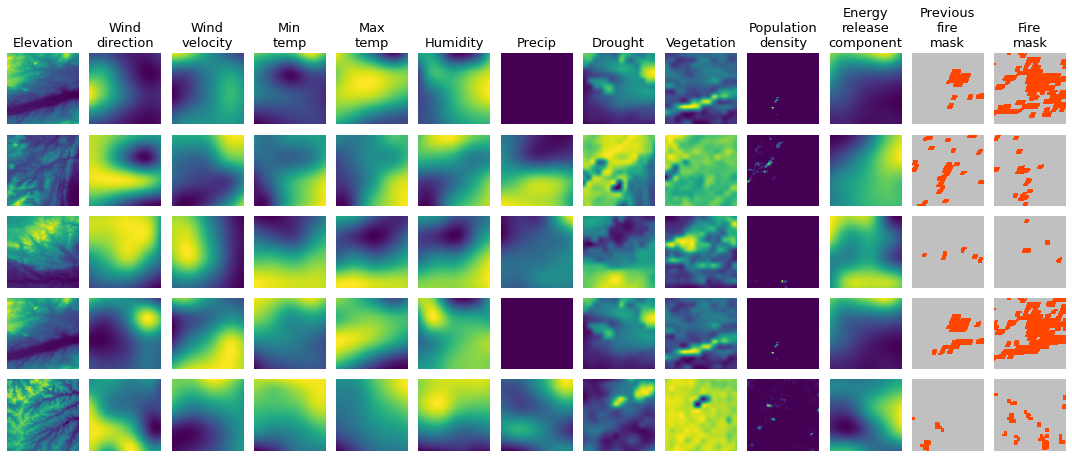

In [20]:
fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
  for j in range(n_features + 1):
    plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j < n_features - 1:
      plt.imshow(inputs[i, :, :, j], cmap='viridis')
    if j == n_features - 1:
      plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
    if j == n_features:
      plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM) 
    plt.axis('off')
plt.tight_layout()

# Get metrics on all features

In [ ]:
def tf_welford(ds, cnt_limit=-1):
    ds_numpy = tfds.as_numpy(ds)
    w_min = np.full(12, float('inf'), dtype=np.float64)
    w_max = np.full(12, float('-inf'), dtype=np.float64)
    w_mean = np.zeros(12, dtype=np.float64)
    w_stdev = np.zeros(12, dtype=np.float64)
    sumsq = np.zeros(12, dtype=np.float64)
    

    cnt = 0.0
    for da in tqdm(ds_numpy):
        da = da[0]
        for i in range(da.shape[0]):
            cnt += 1.0
            sample = da[i]
            img_size = sample.shape[0]
            for j in range(12):
                x = sample[: , :,j]
                x = tf.reshape(x, [-1])
                
                w_min[j] = min(w_min[j], tf.reduce_min(x))
                w_max[j] = max(w_max[j], tf.reduce_max(x))
                
                delta = tf.math.reduce_mean(x - w_mean[j]).numpy()
                w_mean[j] += delta / cnt
                # variance calculation deviates a little from Welford as it uses a batch of 4096 
                sumsq[j] += tf.math.reduce_sum(tf.math.multiply(x, x)).numpy()
                w_stdev[j] = np.sqrt((sumsq[j]/(cnt*(img_size*img_size))) - w_mean[j]*w_mean[j])

            if cnt == float(cnt_limit):
                break 
        else:
            continue
        break

    return w_min, w_max, w_mean, w_stdev


CHK_COUNT = 25000

w_min, w_max, w_mean, w_stdev = tf_welford(dataset, CHK_COUNT)

In [ ]:
for i in range(12):
    print(f'Feature {i+1}:')
    print(f'Min: {w_min[i]}')# Plotting function
    print(f'Max: {w_max[i]}')
    print(f'Mean: {w_mean[i]}')
    print(f'Standard Deviation: {w_stdev[i]}')
    print()

# Train U-net model

### Load callbacks

In [17]:
%load_ext tensorboard

In [18]:
list_of_callbacks = []

list_of_callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                min_delta=0, 
                                patience=2, 
                                verbose=0, 
                                mode='auto', 
                                baseline=None, 
                                restore_best_weights=False))

list_of_callbacks.append(tf.keras.callbacks.ModelCheckpoint('./models/', 
                                     monitor='val_loss', 
                                     verbose=0, 
                                     save_best_only=False,
                                     save_weights_only=False, 
                                     mode='auto', 
                                     save_freq='epoch'))



log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
list_of_callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch='10, 15'))


### Custom Loss functions

In [19]:
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

def focal_loss(labels, logits, alpha, gamma=1.0):
    """Compute the focal loss between `logits` and the ground truth `labels`.
    Focal loss = -alpha_t * (1-pt)^gamma * log(pt)
    where pt is the probability of being classified to the true class.
    pt = p (if true class), otherwise pt = 1 - p. p = sigmoid(logit).
    Args:
    labels: A float32 tensor of size [batch, num_classes].
    logits: A float32 tensor of size [batch, num_classes].
    alpha: A float32 tensor of size [batch_size]
      specifying per-example weight for balanced cross entropy.
    gamma: A float32 scalar modulating loss from hard and easy examples.
    Returns:
    focal_loss: A float32 scalar representing normalized total loss.
    """
    with tf.name_scope('focal_loss'):
        logits = tf.cast(logits, dtype=tf.float32)
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=labels, logits=logits)

    # positive_label_mask = tf.equal(labels, 1.0)
    # probs = tf.sigmoid(logits)
    # probs_gt = tf.where(positive_label_mask, probs, 1.0 - probs)
    # # With gamma < 1, the implementation could produce NaN during back prop.
    # modulator = tf.pow(1.0 - probs_gt, gamma)

    # A numerically stable implementation of modulator.
    if gamma == 0.0:
      modulator = 1.0
    else:
      modulator = tf.exp(-gamma * labels * logits - gamma * tf.log1p(
          tf.exp(-1.0 * logits)))

    loss = modulator * cross_entropy

    weighted_loss = alpha * loss
    focal_loss = tf.reduce_sum(weighted_loss)
    # Normalize by the total number of positive samples.
    focal_loss /= tf.reduce_sum(labels)
    return 

### Load trained Model

In [22]:
custom_objects = {"dice_coef": dice_coef, "iou_coef": iou_coef, "accuracy": tf.keras.metrics.Accuracy(),'focal_tversky_loss': focal_tversky_loss}

# unet = tf.keras.models.load_model('models-baseline/', custom_objects=custom_objects)
unet = tf.keras.models.load_model('models/', custom_objects=custom_objects)


### U-Net v1.0

In [181]:
### Load callbacksfrom keras.layers import Conv2D, BatchNormalization, Conv2DTranspose
def EncoderV1(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    conv = Conv2D(n_filters, 
                  3,  # filter size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)

    conv = Conv2D(n_filters, 
                  3,  # filter size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
  
    conv = BatchNormalization()(conv, training=False)
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv
    skip_connection = conv    
    return next_layer, skip_connection

def DecoderV1(prev_layer_input, skip_layer_input, n_filters=32):
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),
                 strides=(2,2),
                 padding='same')(prev_layer_input)
    merge = tf.concat([up, skip_layer_input], axis=3)
    conv = Conv2D(n_filters, 
                 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3, 
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv


In [182]:
def UNetV1(input_size=(64, 64, 12), n_filters=32, n_classes=1):
    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output 
    """
    # Input size represent the size of 1 image (the size used for pre-processing) 
    inputs = Input(input_size)
    
    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    cblock1 = EncoderV1(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderV1(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderV1(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderV1(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderV1(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderV1(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderV1(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderV1(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderV1(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same', activation="sigmoid")(conv9)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
tic = timeit.default_timer()

epochs = 1

unet = UNetV1(n_filters=128)
unet.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[dice_coef, iou_coef,tf.keras.metrics.Accuracy(),  tf.keras.metrics.AUC()])
results = unet.fit(train_ds, validation_data=valid_ds, epochs=epochs, callbacks=list_of_callbacks)
K.clear_session()

toc = timeit.default_timer()
print(f"Took {toc - tic} to train")


### U-Net v2.0

In [42]:
### Load callbacks

def EncoderV2(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

def DecoderV2(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = LeakyReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    
    dropout_layer = tf.keras.layers.Dropout(0.5)(batch_norm2)

    act2 = LeakyReLU()(dropout_layer)
    
    return act2

def UNetV2(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = EncoderV2(input1, 64)
    skip2, encoder_2 = EncoderV2(encoder_1, 64*2)
    skip3, encoder_3 = EncoderV2(encoder_2, 64*4)
    skip4, encoder_4 = EncoderV2(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = DecoderV2(conv_block, skip4, 64*8)
    decoder_2 = DecoderV2(decoder_1, skip3, 64*4)
    decoder_3 = DecoderV2(decoder_2, skip2, 64*2)
    decoder_4 = DecoderV2(decoder_3, skip1, 64)
    
#     out = Conv2D(2, 1, padding="same", activation="sigmoid")(decoder_4)
    out = Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model


In [43]:
input_shape = (64, 64, 12)
unet = UNetV2(input_shape)

# unet.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
unet.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001), loss=focal_tversky_loss, metrics=[dice_coef, iou_coef])

In [ ]:
tic = timeit.default_timer()

# Train the model, doing validation at the end of each epoch.
epochs = 10
results = unet.fit(train_ds, validation_data=valid_ds, epochs=epochs, callbacks=list_of_callbacks)

K.clear_session()

toc = timeit.default_timer()
print(f"Took {toc - tic} to train")

### U-Net v3.0

In [85]:
def EncoderV3(inputs, n_filters=32, dropout_prob=0.3, activation='relu', init='he_normal', max_pooling=True):
    conv = Conv2D(n_filters, 
                  3,  # filter size
                  activation=activation,
                  padding='same',
                  kernel_initializer=init)(inputs)

    conv = Conv2D(n_filters, 
                  3,  # filter size
                  activation=activation,
                  padding='same',
                  kernel_initializer=init)(conv)
  
    conv = BatchNormalization()(conv, training=False)
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv
    skip_connection = conv    
    return next_layer, skip_connection

def DecoderV3(prev_layer_input, skip_layer_input, n_filters=32, activation='relu', init='HeNormal',):
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),
                 strides=(2,2),
                 padding='same')(prev_layer_input)
    merge = tf.concat([up, skip_layer_input], axis=3)
    conv = Conv2D(n_filters, 
                 3,  
                 activation=activation,
                 padding='same',
                 kernel_initializer=init)(merge)
    conv = Conv2D(n_filters,
                 3, 
                 activation=activation,
                 padding='same',
                 kernel_initializer=init)(conv)
    return conv


In [86]:
def UNetV3(input_size=(64, 64, 12), n_filters=32, drop_out_prob=0.3, n_classes=1, n_layers=3, init='he_normal', activation='relu'):
    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output 
    """
    # Input size represent the size of 1 image (the size used for pre-processing) 
    inputs = Input(input_size)
    
    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    
    encodeBlocks = []
    
    cblock = EncoderV3(inputs, n_filters, dropout_prob=0, max_pooling=True, init=init, activation=activation)
    encodeBlocks.append(cblock)
    multiplier = 2
    for i in range(n_layers):
        cblock = EncoderV3(encodeBlocks[-1][0], n_filters*multiplier,dropout_prob=drop_out_prob, max_pooling=True, init=init, activation=activation)
        encodeBlocks.append(cblock) 
        multiplier *= 2

    cblock = EncoderV3(encodeBlocks[-1][0],n_filters*multiplier,dropout_prob=drop_out_prob, max_pooling=False, init=init, activation=activation)
    encodeBlocks.append(cblock) 
    multiplier /= 2

    decodeBlocks = []
    ublock = DecoderV3(encodeBlocks.pop()[0], encodeBlocks.pop()[1],  n_filters * multiplier, init=init, activation=activation)
    decodeBlocks.append(ublock)
    multiplier /= 2

    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    for i in range(n_layers):
        ublock = DecoderV3(decodeBlocks[-1], encodeBlocks.pop()[1],  n_filters * multiplier, init=init, activation=activation)
        decodeBlocks.append(ublock) 
        multiplier /= 2

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv = Conv2D(n_filters,
                 3,
                 activation=activation,
                 padding='same',
                 kernel_initializer=init)(decodeBlocks[-1])

    outputLayer = Conv2D(n_classes, 1, padding='same', activation="sigmoid")(conv)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=outputLayer)

    return model

In [34]:
unet = UNetV3(n_filters=161, drop_out_prob=0.475,
                       n_layers=3, init='he_normal', activation='selu')

unet.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-07), loss=tf.keras.losses.BinaryCrossentropy(),  metrics=[dice_coef, iou_coef,tf.keras.metrics.Accuracy(),  tf.keras.metrics.AUC()])
tic = timeit.default_timer()

# Train the model, doing validation at the end of each epoch.
epochs = 3
results = unet.fit(train_ds, validation_data=valid_ds, epochs=epochs, callbacks=list_of_callbacks)

K.clear_session()

toc = timeit.default_timer()
print(f"Took {toc - tic} to train")

Epoch 1/3
  46809/Unknown - 4837s 103ms/step - loss: 0.4114 - dice_coef: 0.4467 - iou_coef: 0.1990 - accuracy: 6.0654e-06 - auc: 0.8208INFO:tensorflow:Assets written to: ./models\assets
46809/46809 [==============================] - 4990s 106ms/step - loss: 0.4114 - dice_coef: 0.4467 - iou_coef: 0.1990 - accuracy: 6.0654e-06 - auc: 0.8208 - val_loss: 0.5227 - val_dice_coef: 0.4821 - val_iou_coef: 0.1886 - val_accuracy: 0.0045 - val_auc: 0.7884
Epoch 2/3
46809/46809 [==============================] - 5027s 107ms/step - loss: 0.4026 - dice_coef: 0.4541 - iou_coef: 0.2028 - accuracy: 7.8872e-06 - auc: 0.8290 - val_loss: 0.5538 - val_dice_coef: 0.4844 - val_iou_coef: 0.1897 - val_accuracy: 0.0070 - val_auc: 0.7844
Epoch 3/3
46809/46809 [==============================] - 5088s 109ms/step - loss: 0.3966 - dice_coef: 0.4598 - iou_coef: 0.2057 - accuracy: 1.1171e-05 - auc: 0.8346 - val_loss: 0.5849 - val_dice_coef: 0.4843 - val_iou_coef: 0.1898 - val_accuracy: 0.0101 - val_auc: 0.7794
Took 151

### U-Net v4.0

* Add dropout layers
* Make programatic architecture
* Increase model size
* Maybe try to previous upsampling and downsampling layers instead of inception

In [20]:
def conv2d_block(input_tensor,
                 n_filters,
                 kernel_size=3,
                 batchnorm=True,
                 strides=1,
                 dilation_rate=1,
                 recurrent=1):

    # A wrapper of the Keras Conv2D block to serve as a building block for downsampling layers
    # Includes options to use batch normalization, dilation and recurrence

    conv = Conv2D(filters=n_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  kernel_initializer="he_normal",
                  padding="same",
                  dilation_rate=dilation_rate)(input_tensor)
    if batchnorm:
        conv = BatchNormalization()(conv)
    output = LeakyReLU(alpha=alpha)(conv)

    for _ in range(recurrent - 1):
        conv = Conv2D(filters=n_filters,
                      kernel_size=kernel_size,
                      strides=1,
                      kernel_initializer="he_normal",
                      padding="same",
                      dilation_rate=dilation_rate)(output)
        if batchnorm:
            conv = BatchNormalization()(conv)
        res = LeakyReLU(alpha=alpha)(conv)
        output = Add()([output, res])

    return output
    

def inception_block(input_tensor,
                    n_filters,
                    kernel_size=3,
                    strides=1,
                    batchnorm=True,
                    recurrent=1,
                    layers=[]):

    # Inception-style convolutional block similar to InceptionNet
    # The first convolution follows the function arguments, while subsequent inception convolutions follow the parameters in
    # argument, layers

    # layers is a nested list containing the different secondary inceptions in the format of (kernel_size, dil_rate)

    # E.g => layers=[ [(3,1),(3,1)], [(5,1)], [(3,1),(3,2)] ]
    # This will implement 3 sets of secondary convolutions
    # Set 1 => 3x3 dil = 1 followed by another 3x3 dil = 1
    # Set 2 => 5x5 dil = 1
    # Set 3 => 3x3 dil = 1 followed by 3x3 dil = 2

    res = conv2d_block(input_tensor,
                       n_filters=n_filters,
                       kernel_size=kernel_size,
                       strides=strides,
                       batchnorm=batchnorm,
                       dilation_rate=1,
                       recurrent=recurrent)

    temp = []
    for layer in layers:
        local_res = res
        for conv in layer:
            incep_kernel_size = conv[0]
            incep_dilation_rate = conv[1]
            local_res = conv2d_block(local_res,
                                     n_filters=n_filters,
                                     kernel_size=incep_kernel_size,
                                     strides=1,
                                     batchnorm=batchnorm,
                                     dilation_rate=incep_dilation_rate,
                                     recurrent=recurrent)
        temp.append(local_res)

    temp = concatenate(temp)
    res = conv2d_block(temp,
                       n_filters=n_filters,
                       kernel_size=1,
                       strides=1,
                       batchnorm=batchnorm,
                       dilation_rate=1)

    shortcut = conv2d_block(input_tensor,
                            n_filters=n_filters,
                            kernel_size=1,
                            strides=strides,
                            batchnorm=batchnorm,
                            dilation_rate=1)
    if batchnorm:
        shortcut = BatchNormalization()(shortcut)

    output = Add()([shortcut, res])
    return output


def transpose_block(input_tensor,
                    skip_tensor,
                    n_filters,
                    kernel_size=3,
                    strides=1,
                    batchnorm=True,
                    recurrent=1):

    # A wrapper of the Keras Conv2DTranspose block to serve as a building block for upsampling layers

    shape_x = K.int_shape(input_tensor)
    shape_xskip = K.int_shape(skip_tensor)

    conv = Conv2DTranspose(filters=n_filters,
                           kernel_size=kernel_size,
                           padding='same',
                           strides=(shape_xskip[1] // shape_x[1],
                                    shape_xskip[2] // shape_x[2]),
                           kernel_initializer="he_normal")(input_tensor)
    conv = LeakyReLU(alpha=alpha)(conv)

    act = conv2d_block(conv,
                       n_filters=n_filters,
                       kernel_size=kernel_size,
                       strides=1,
                       batchnorm=batchnorm,
                       dilation_rate=1,
                       recurrent=recurrent)
    output = Concatenate(axis=3)([act, skip_tensor])
    return output


def expend_as(tensor, rep):

    # Anonymous lambda function to expand the specified axis by a factor of argument, rep.
    # If tensor has shape (512,512,N), lambda will return a tensor of shape (512,512,N*rep), if specified axis=2

    my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                       arguments={'repnum': rep})(tensor)
    return my_repeat


def AttnGatingBlock(x, g, inter_shape):

    shape_x = K.int_shape(x)
    shape_g = K.int_shape(g)
    

    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = Conv2D(filters=inter_shape,
                   kernel_size=1,
                   strides=1,
                   padding='same')(g)

    # Getting the x signal to the same shape as the gating signal
    theta_x = Conv2D(filters=inter_shape,
                     kernel_size=3,
                     strides=(shape_x[1] // shape_g[1],
                              shape_x[2] // shape_g[2]),
                     padding='same')(x)

    # Element-wise addition of the gating and x signals
#     add_xg = Add([phi_g, theta_x])
    add_xg = Add()([phi_g, theta_x])
    add_xg = Activation('relu')(add_xg)

    # 1x1x1 convolution
    psi = Conv2D(filters=1, kernel_size=1, padding='same')(add_xg)
    psi = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(psi)

    # Upsampling psi back to the original dimensions of x signal
    upsample_sigmoid_xg = UpSampling2D(
        size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(psi)

    # Expanding the filter axis to the number of filters in the original x signal
    upsample_sigmoid_xg = expend_as(upsample_sigmoid_xg, shape_x[3])

    # Element-wise multiplication of attention coefficients back onto original x signal
    attn_coefficients = multiply([upsample_sigmoid_xg, x])

    # Final 1x1x1 convolution to consolidate attention signal to original x dimensions
    
    output = Conv2D(filters=shape_x[3],
                    kernel_size=1,
                    strides=1,
                    padding='same')(attn_coefficients)
    output = BatchNormalization()(output)
    return output

In [21]:
def network(input_img, n_filters=16, batchnorm=True):

    # contracting path

    c0 = inception_block(input_img,
                         n_filters=n_filters,
                         batchnorm=batchnorm,
                         strides=1,
                         recurrent=2,
                         layers=[[(3, 1), (3, 1)], [(3, 2)]])  # 512x512x512

    c1 = inception_block(c0,
                         n_filters=n_filters * 2,
                         batchnorm=batchnorm,
                         strides=2,
                         recurrent=2,
                         layers=[[(3, 1), (3, 1)], [(3, 2)]])  # 256x256x256

    c2 = inception_block(c1,
                         n_filters=n_filters * 4,
                         batchnorm=batchnorm,
                         strides=2,
                         recurrent=2,
                         layers=[[(3, 1), (3, 1)], [(3, 2)]])  # 128x128x128

    c3 = inception_block(c2,
                         n_filters=n_filters * 8,
                         batchnorm=batchnorm,
                         strides=2,
                         recurrent=2,
                         layers=[[(3, 1), (3, 1)], [(3, 2)]])  # 64x64x64

    # bridge

    b0 = inception_block(c3,
                         n_filters=n_filters * 16,
                         batchnorm=batchnorm,
                         strides=2,
                         recurrent=2,
                         layers=[[(3, 1), (3, 1)], [(3, 2)]])  # 32x32x32

    # expansive path

    attn0 = AttnGatingBlock(c3, b0, n_filters * 16)
    u0 = transpose_block(b0,
                         attn0,
                         n_filters=n_filters * 8,
                         batchnorm=batchnorm,
                         recurrent=2)  # 64x64x64

    attn1 = AttnGatingBlock(c2, u0, n_filters * 8)
    u1 = transpose_block(u0,
                         attn1,
                         n_filters=n_filters * 4,
                         batchnorm=batchnorm,
                         recurrent=2)  # 128x128x128

    attn2 = AttnGatingBlock(c1, u1, n_filters * 4)
    u2 = transpose_block(u1,
                         attn2,
                         n_filters=n_filters * 2,
                         batchnorm=batchnorm,
                         recurrent=2)  # 256x256x256

    u3 = transpose_block(u2,
                         c0,
                         n_filters=n_filters,
                         batchnorm=batchnorm,
                         recurrent=2)  # 512x512x512

    outputs = Conv2D(filters=1, kernel_size=1, strides=1,
                     activation='sigmoid')(u3)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [22]:
alpha = 0.1

input_shape = (64, 64, 12)
inputs = Input(input_shape)
 
unet = network(inputs)

unet.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001), loss=tf.keras.losses.BinaryCrossentropy(),  metrics=[dice_coef, iou_coef,tf.keras.metrics.Accuracy(),  tf.keras.metrics.AUC()])
tic = timeit.default_timer()

# Train the model, doing validation at the end of each epoch.
epochs = 3
results = unet.fit(train_ds, validation_data=valid_ds, epochs=epochs, callbacks=list_of_callbacks)

K.clear_session()

toc = timeit.default_timer()
print(f"Took {toc - tic} to train")

Epoch 1/3
   4681/Unknown - 580s 119ms/step - loss: 0.4898 - dice_coef: 0.4125 - iou_coef: 0.1860 - accuracy: 0.0037 - auc: 0.7484INFO:tensorflow:Assets written to: ./models\assets
4681/4681 [==============================] - 616s 127ms/step - loss: 0.4898 - dice_coef: 0.4125 - iou_coef: 0.1860 - accuracy: 0.0037 - auc: 0.7484 - val_loss: 0.4952 - val_dice_coef: 0.3704 - val_iou_coef: 0.1374 - val_accuracy: 7.8594e-04 - val_auc: 0.7170
Epoch 2/3
4681/4681 [==============================] - 582s 124ms/step - loss: 0.3885 - dice_coef: 0.4886 - iou_coef: 0.2121 - accuracy: 0.0026 - auc: 0.8372 - val_loss: 0.4935 - val_dice_coef: 0.3805 - val_iou_coef: 0.1419 - val_accuracy: 2.3656e-04 - val_auc: 0.7341
Epoch 3/3
4681/4681 [==============================] - 578s 123ms/step - loss: 0.3541 - dice_coef: 0.5313 - iou_coef: 0.2366 - accuracy: 0.0022 - auc: 0.8673 - val_loss: 0.4968 - val_dice_coef: 0.3909 - val_iou_coef: 0.1474 - val_accuracy: 1.6653e-04 - val_auc: 0.7420
Took 1776.0285364 to t

### Test Model on training set

In [ ]:
a_iter = iter(train_ds)
inp, lab = next(a_iter)
dataset = tf.data.Dataset.from_tensors((inp, lab))
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

b_iter = iter(valid_ds)
inp, lab = next(b_iter)
val_dataset = tf.data.Dataset.from_tensors((inp, lab))
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
epochs = 100
unet = UNetV3(n_filters=32, n_layers=5)

# unet.compile(optimizer=tf.keras.optimizers.Adam(beta_1=0.99, learning_rate=0.00001), loss=tversky_loss, metrics=[dice_coef,iou_coef])
# unet = U_Net(input_shape)
# unet.compile(optimizer=tf.keras.optimizers.RMSprop(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[dice_coef,tf.keras.metrics.Accuracy()])
unet.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[dice_coef,iou_coef,tf.keras.metrics.Accuracy(),  tf.keras.metrics.AUC()])

hist = unet.fit(dataset, epochs=epochs)
metrics = unet.evaluate(dataset)
print(metrics)

K.clear_session()

### Bayesian Hyperparamater Tuning

In [46]:
a_iter = iter(train_ds)
inp, lab = next(a_iter)
dataset = tf.data.Dataset.from_tensors((inp, lab))
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

b_iter = iter(valid_ds)
inp, lab = next(b_iter)
val_dataset = tf.data.Dataset.from_tensors((inp, lab))
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [113]:
epochs = 5
dim_learning_rate = Real(low=1e-7, high=1e-4, prior='log-uniform',
                         name='learning_rate')
dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')
dim_num_dense_nodes = Integer(low=4, high=256, name='num_dense_nodes')
dim_activation = Categorical(categories=['relu', 'selu', 'elu', tf.keras.layers.LeakyReLU()],
                             name='activation')
dim_dropout = Real(low=0.1, high=0.5, name='dropout')
dim_weight_init = Categorical(categories=['he_normal', 'he_uniform'],
                             name='weight_init')
# dim_batch_size = Integer(low=1, high=200, name='batch_size')


dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation,
              dim_dropout,
              dim_weight_init]

default_parameters = [1e-5, 3, 128, 'relu', 0.2, 'he_normal']
best_dice_coef = float('inf')

In [114]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers, num_dense_nodes, activation,
              dropout, weight_init):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    dropout:           Dropout rate 
    weight_init:       Weight initialization for every layer
    batch_size:        Batch size used for training
    """

    try: 
        # Print the hyper-parameters.
        print('learning rate: {0:.1e}'.format(learning_rate))
        print('num_dense_layers:', num_dense_layers)
        print('num_dense_nodes:', num_dense_nodes)
        print('activation:', activation)
        print('dropout:', dropout)
        print('weight_init:', weight_init)
        print()

        # Create the neural network with these hyper-parameters.
        model = UNetV3(n_filters=num_dense_layers, drop_out_prob=dropout,
                       n_layers=num_dense_layers, init=weight_init, activation=activation)

        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[dice_coef,iou_coef])


        # Dir-name for the TensorBoard log-files.
        #     log_dir = log_dir_name(learning_rate, num_dense_layers,
        #                            num_dense_nodes, activation)

        # Create a callback-function for Keras which will be
        # run after each epoch has ended during training.
        # This saves the log-files for TensorBoard.
        # Note that there are complications when histogram_freq=1.
        # It might give strange errors and it also does not properly
        # support Keras data-generators for the validation-set.
        #     callback_log = TensorBoard(
        #         log_dir=log_dir,
        #         histogram_freq=0,
        #         write_graph=True,
        #         write_grads=False,
        #         write_images=False)
        
        callback_log =tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                min_delta=0, 
                                patience=1, 
                                verbose=0, 
                                mode='auto', 
                                baseline=None, 
                                restore_best_weights=False)

        # Use Keras to train the model.
        history = model.fit(train_ds,
                            epochs=epochs,
                            validation_data=valid_ds,
                           callbacks=[callback_log]) 
#         history = model.fit(dataset,
#                             epochs=3,
#                             validation_data=val_dataset,
#                             callbacks=[callback_log]) 


        # Get the classification accuracy on the validation-set
        # after the last training-epoch.
        dice_coef_score = history.history['val_dice_coef'][-1]

        # Print the classification accuracy.
        print()
        print(f"Dice Coefficient: {dice_coef_score}")
        print()

        # Save the model if it improves on the best-found performance.
        # We use the global keyword so we update the variable outside
        # of this function.
        global best_dice_coef

        # If the classification accuracy of the saved model is improved ...
        if dice_coef_score > best_dice_coef:
            # Save the new model to harddisk.
            model.save(path_best_model)

            # Update the classification accuracy.
            best_accuracy = dice_coef_score

        # Delete the Keras model with these hyper-parameters from memory.
        del model

        # Clear the Keras session, otherwise it will keep adding new
        # models to the same TensorFlow graph each time we create
        # a model with a different set of hyper-parameters.
        K.clear_session()

        # NOTE: Scikit-optimize does minimization so it tries to
        # find a set of hyper-parameters with the LOWEST fitness-value.
        # Because we are interested in the HIGHEST classification
        # accuracy, we need to negate this number so it can be minimized.
        if dice_coef_score == np.nan:
            return -1
        return -dice_coef_score
    except Exception as e:
        print(e)
        del model
        K.clear_session()
        return -1
# This function exactly comes from :Hvass-Labs, TensorFlow-Tutorials

In [100]:
fitness(x=default_parameters)


learning rate: 1.0e-05
num_dense_layers: 3
num_dense_nodes: 128
activation: relu
dropout: 0.2
weight_init: he_normal

Epoch 1/3
2728/2728 [==============================] - 81s 28ms/step - loss: 0.7723 - dice_coef: 0.2698 - iou_coef: 0.1419 - accuracy: 5.8350e-06 - auc: 0.4552 - val_loss: 0.6902 - val_dice_coef: 0.3997 - val_iou_coef: 0.2304 - val_accuracy: 0.0000e+00 - val_auc: 0.4626
Epoch 2/3
2728/2728 [==============================] - 76s 28ms/step - loss: 0.6727 - dice_coef: 0.2648 - iou_coef: 0.1369 - accuracy: 0.0000e+00 - auc: 0.4693 - val_loss: 0.6805 - val_dice_coef: 0.3943 - val_iou_coef: 0.2253 - val_accuracy: 0.0000e+00 - val_auc: 0.5005
Epoch 3/3
2728/2728 [==============================] - 75s 28ms/step - loss: 0.6532 - dice_coef: 0.2622 - iou_coef: 0.1347 - accuracy: 0.0000e+00 - auc: 0.4711 - val_loss: 0.6750 - val_dice_coef: 0.3887 - val_iou_coef: 0.2204 - val_accuracy: 0.0000e+00 - val_auc: 0.5000

Dice Coefficient: 0.3887310326099396



-0.3887310326099396

In [115]:
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=40,
                            x0=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 3
num_dense_nodes: 128
activation: relu
dropout: 0.2
weight_init: he_normal

Epoch 1/3
2728/2728 [==============================] - 59s 20ms/step - loss: 0.6709 - dice_coef: 0.2632 - iou_coef: 0.1345 - val_loss: 0.6722 - val_dice_coef: 0.3757 - val_iou_coef: 0.2055
Epoch 2/3
2728/2728 [==============================] - 52s 19ms/step - loss: 0.5810 - dice_coef: 0.2423 - iou_coef: 0.1167 - val_loss: 0.7185 - val_dice_coef: 0.3163 - val_iou_coef: 0.1628

Dice Coefficient: 0.31628209352493286

learning rate: 7.6e-05
num_dense_layers: 1
num_dense_nodes: 250
activation: selu
dropout: 0.4893953247706935
weight_init: he_normal

Epoch 1/3
2728/2728 [==============================] - 34s 12ms/step - loss: 0.5200 - dice_coef: 0.2118 - iou_coef: 0.1000 - val_loss: 0.7120 - val_dice_coef: 0.2644 - val_iou_coef: 0.1313
Epoch 2/3
2728/2728 [==============================] - 31s 11ms/step - loss: 0.4830 - dice_coef: 0.1902 - iou_coef: 0.0868 - val_loss: 0.7333 

learning rate: 1.3e-05
num_dense_layers: 5
num_dense_nodes: 104
activation: relu
dropout: 0.14962694662747297
weight_init: he_normal

Epoch 1/3
2728/2728 [==============================] - 95s 33ms/step - loss: 0.5218 - dice_coef: 0.2281 - iou_coef: 0.1046 - val_loss: 0.7946 - val_dice_coef: 0.2492 - val_iou_coef: 0.1266
Epoch 2/3
2728/2728 [==============================] - 102s 37ms/step - loss: 0.4503 - dice_coef: 0.2409 - iou_coef: 0.1031 - val_loss: 0.8104 - val_dice_coef: 0.2411 - val_iou_coef: 0.1222

Dice Coefficient: 0.2410852164030075

learning rate: 1.6e-05
num_dense_layers: 1
num_dense_nodes: 96
activation: selu
dropout: 0.5
weight_init: he_uniform

Epoch 1/3
2728/2728 [==============================] - 54s 19ms/step - loss: 0.7596 - dice_coef: 0.2365 - iou_coef: 0.1166 - val_loss: 0.7489 - val_dice_coef: 0.3354 - val_iou_coef: 0.1777
Epoch 2/3
2728/2728 [==============================] - 53s 19ms/step - loss: 0.6014 - dice_coef: 0.2110 - iou_coef: 0.0990 - val_loss: 0.7263

Epoch 1/3
2728/2728 [==============================] - 53s 18ms/step - loss: 0.7202 - dice_coef: 0.2723 - iou_coef: 0.1393 - val_loss: 0.6715 - val_dice_coef: 0.4067 - val_iou_coef: 0.2286
Epoch 2/3
2728/2728 [==============================] - 50s 18ms/step - loss: 0.7049 - dice_coef: 0.2713 - iou_coef: 0.1378 - val_loss: 0.6635 - val_dice_coef: 0.4023 - val_iou_coef: 0.2240
Epoch 3/3
2728/2728 [==============================] - 51s 19ms/step - loss: 0.6900 - dice_coef: 0.2702 - iou_coef: 0.1363 - val_loss: 0.6567 - val_dice_coef: 0.3978 - val_iou_coef: 0.2193

Dice Coefficient: 0.3977930247783661

learning rate: 3.6e-07
num_dense_layers: 2
num_dense_nodes: 69
activation: selu
dropout: 0.47569324294507187
weight_init: he_uniform

Epoch 1/3
2728/2728 [==============================] - 50s 18ms/step - loss: 1.4363 - dice_coef: 0.2280 - iou_coef: 0.1186 - val_loss: 1.6523 - val_dice_coef: 0.4215 - val_iou_coef: 0.2505
Epoch 2/3
2728/2728 [==============================] - 56s 20ms/step - 

Epoch 2/3
2728/2728 [==============================] - 32s 12ms/step - loss: 0.6929 - dice_coef: 0.2676 - iou_coef: 0.1393 - val_loss: 0.6932 - val_dice_coef: 0.4039 - val_iou_coef: 0.2339

Dice Coefficient: 0.40394675731658936

learning rate: 1.0e-07
num_dense_layers: 1
num_dense_nodes: 21
activation: <keras.layers.advanced_activations.LeakyReLU object at 0x00000275BA11F130>
dropout: 0.4696581785065953
weight_init: he_normal

Epoch 1/3
2728/2728 [==============================] - 33s 12ms/step - loss: 0.6906 - dice_coef: 0.2670 - iou_coef: 0.1389 - val_loss: 0.6928 - val_dice_coef: 0.4035 - val_iou_coef: 0.2335
Epoch 2/3
2728/2728 [==============================] - 32s 12ms/step - loss: 0.6903 - dice_coef: 0.2670 - iou_coef: 0.1388 - val_loss: 0.6927 - val_dice_coef: 0.4035 - val_iou_coef: 0.2335
Epoch 3/3
2728/2728 [==============================] - 32s 12ms/step - loss: 0.6901 - dice_coef: 0.2670 - iou_coef: 0.1388 - val_loss: 0.6927 - val_dice_coef: 0.4034 - val_iou_coef: 0.2334

D

In [120]:
search_result

          fun: -0.5220789909362793
    func_vals: array([-0.31628209, -0.24740727, -0.26252425, -0.34899777, -0.1919875 ,
       -0.22362046, -0.39116454, -0.20787784, -0.24398266, -0.27846912,
       -0.3442947 , -0.16802487, -0.39538839, -0.24108522, -0.27933729,
       -0.37190792, -0.27781576, -0.39503801, -0.22260784, -0.12458717,
       -0.30536002, -0.40581787, -0.14797132, -0.44214225, -0.40373373,
       -0.39779302, -0.41672477, -0.29279456, -0.46616989, -0.52207899,
       -0.41050169, -0.3083539 , -0.40399423, -0.38106743, -0.42785794,
       -0.40421048, -0.40394676, -0.40341207, -0.40356949, -0.43586737])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1867146381), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noi

In [116]:
search_result.x

[1e-07, 3, 161, 'selu', 0.4757355752128499, 'he_normal']

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

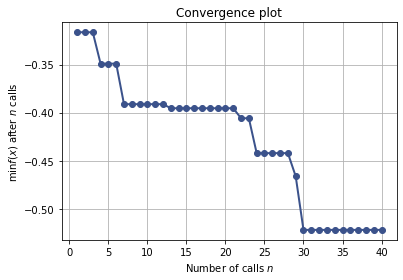

In [117]:
from skopt.plots import plot_convergence, plot_objective_2D, plot_objective
plot_convergence(search_result) 


<Figure size 800x960 with 0 Axes>

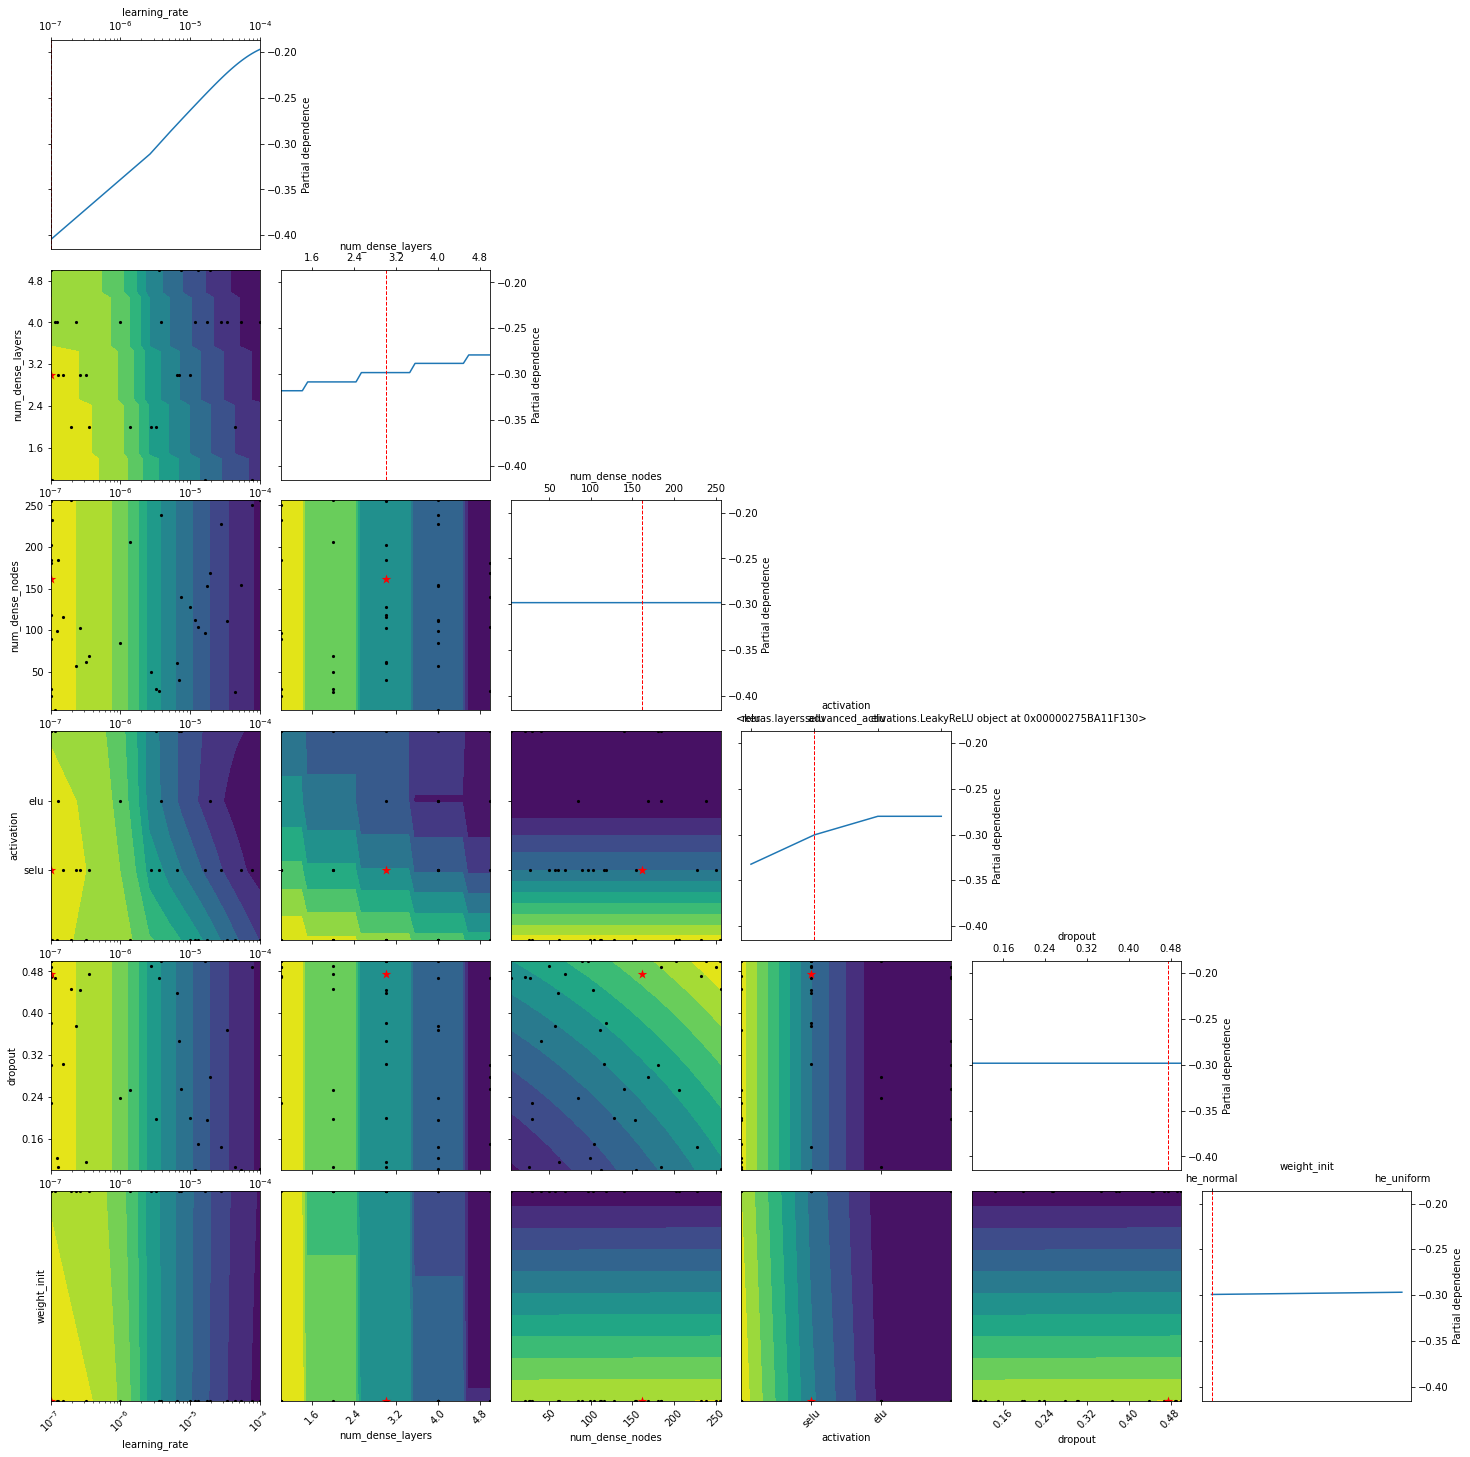

In [123]:
dim_names = ['learning_rate', 'num_dense_layers', 'num_dense_nodes', 'activation', 'dropout', 'weight_init']

from matplotlib.pyplot import figure

figure(figsize=(10, 12), dpi=80)

plot_objective(result=search_result, dimensions=dim_names, size=3.5)
plt.savefig("all_dimen.png", dpi=400)

### Tensorboard

In [165]:
%tensorboard --logdir=C:/Users/kamen/OneDrive/Documents/shared_drive/Thesis/Wildfire_Data_Generator/logs/fit  --port=6006  --host localhost

### Evaluation 

In [23]:
test_iter = iter(test_ds)
inputs, labels = next(test_iter) 
preds = (unet.predict(inputs) > 0.5).astype("float32")


In [23]:
i = 0
probPreds = []
preds = []
labels = []
for img, lab in test_ds:
    probPred = unet.predict(img).astype("float32")
    pred = (probPred > 0.5).astype("float32")
    
    probPreds.append(probPred)
    preds.append(pred)
    labels.append(lab.numpy())

    i += 1
    if i == -1:
        break

probPreds = np.concatenate(probPreds)
preds = np.concatenate(preds)
labels = np.concatenate(labels)

In [24]:
labels.shape, preds.shape, probPreds.shape

((53544, 64, 64, 1), (53544, 64, 64, 1), (53544, 64, 64, 1))

In [25]:
with tf.device('/CPU:0'):

    m = tf.keras.metrics.Accuracy()
    m.reset_state()
    m.update_state(labels, preds)

    print(f'Accuracy: {m.result().numpy()}')


Accuracy: 0.7882840633392334


In [26]:
with tf.device('/CPU:0'):
    diceScore = dice_coef(labels, preds)
    print(f'Dice Coefficient score: {diceScore}')


Dice Coefficient score: 0.6297155022621155


In [27]:
with tf.device('/CPU:0'):
    IOUscore = iou_coef(labels, preds)
    print(f'IOU score: {IOUscore}')

IOU score: 0.27014198899269104


Random Agent: ROC AUC=0.500
U-Net: ROC AUC=0.825


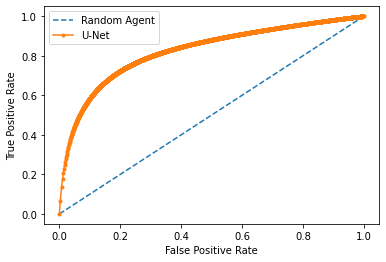

In [40]:

testy = labels.flatten()
ns_probs = [0 for _ in range(len(testy))]
lr_probs = probPreds.flatten()
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)

ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)

print('Random Agent: ROC AUC=%.3f' % (ns_auc))
print('U-Net: ROC AUC=%.3f' % (lr_auc))

pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Agent')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='U-Net')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

U-Net: f1=0.669 auc=0.719


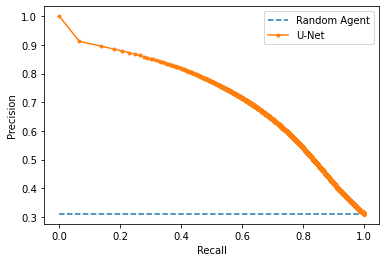

In [41]:
testy = labels.flatten()
lr_probs = probPreds.flatten()
yhat = preds.flatten()


# calculate precision and recall for each threshold
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
# calculate scores
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('U-Net: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Random Agent')
pyplot.plot(lr_recall, lr_precision, marker='.', label='U-Net')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

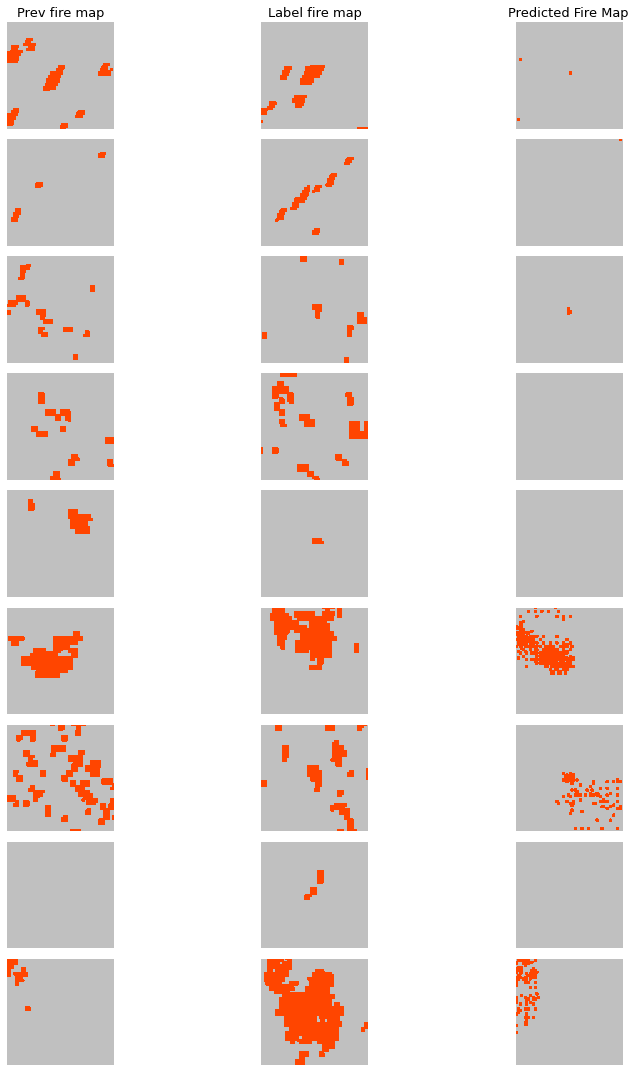

In [42]:
fig = plt.figure(figsize=(15,15))

TITLES = ['Prev fire map', 'Label fire map', 'Predicted Fire Map']
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
n_rows = 9
for i in range(n_rows):
  for j in range(len(TITLES)):
    plt.subplot(n_rows, 3 + 1, i * (3 + 1) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j == 0 :
      plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
    if j == 1:
      plt.imshow(labels[i, :, :], cmap=CMAP, norm=NORM)
    if j == 2:
      plt.imshow(preds[i, :, :], cmap=CMAP, norm=NORM) 
    plt.axis('off')
plt.tight_layout()